In [2]:
%matplotlib inline

In [22]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class BernoulliArm():

  def __init__(self, p):
    self.p = p

  def step(self):
    if np.random.random() > self.p:
      return 1
    else:
      return 0

class NormalArm():

  def __init__(self, mu, var):
    self.mu = mu
    self.var = var

  def step(self):
    return np.random.normal(self.mu, self.var)

class EpsilonGreedyBandit():

  def __init__(self, epsilon, k):
    self.epsilon = epsilon
    self.counts = [0] * k
    self.exp = [0.0] * k
    self.k = k

  def choose_action(self):
    if np.random.random() < self.epsilon:
      return np.random.randint(self.k)
    else:
      return np.argmax(self.exp)

  def update(self, idx, reward):
    self.exp[idx] = (self.exp[idx] * self.counts[idx] + reward) / (self.counts[idx] + 1)
    self.counts[idx] += 1

  def reset(self):
    self.counts = [0] * self.k
    self.exp = [0.0] * self.k

def test_bandit(bandit, arms, n_episodes, n_steps, *args, **kwargs):    
    chosen_arms = np.zeros((n_episodes, n_steps))
    avg_reward = np.zeros(n_steps)
    cumulative_reward = np.zeros(n_steps)
    best_cnt = np.zeros(n_steps)
    max_mu = max(map(lambda x: x.mu, arms))
    for episode in range(n_episodes):
        ep_reward = 0
        bandit.reset()
        for step in range(n_steps):
            chosen_arm = bandit.choose_action()
            chosen_arms[episode,step] = chosen_arm
            reward = arms[chosen_arm].step()
            ep_reward += reward
            avg_reward[step] += reward
            bandit.update(chosen_arm, reward)
            if arms[chosen_arm].mu == max_mu:
                best_cnt[step] += 1.0
                
    cumulative_reward[0] = avg_reward[0]
    best_cnt /= float(n_episodes)
    for i in range(1, n_steps):
      cumulative_reward[i] += cumulative_reward[i - 1] + avg_reward[i]
      best_cnt[i] += best_cnt[i - 1]
    avg_reward /= n_episodes
    cumulative_reward /= n_episodes
    return chosen_arms, avg_reward, cumulative_reward, best_cnt

In [4]:
chosen_arms, avg_reward, cumulative_reward = test_bandit(bandit = EpsilonGreedyBandit(0.1,2), arms = [BernoulliArm(p=0.1), 
    BernoulliArm(p=0.9)], n_episodes=10, n_steps=50)

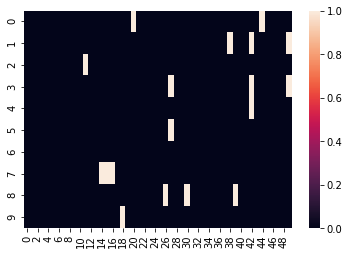

In [5]:
# Heatmap of the decisions - we rarely pick the wrong item
sns.heatmap(chosen_arms)

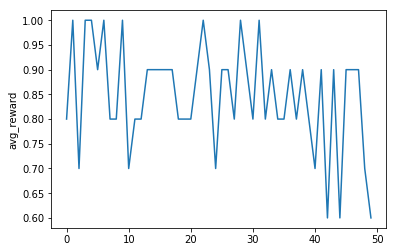

In [6]:
import matplotlib.pyplot as plt
plt.plot(avg_reward)
plt.ylabel('avg_reward')
plt.show()

# Average reward for the two arms scenario

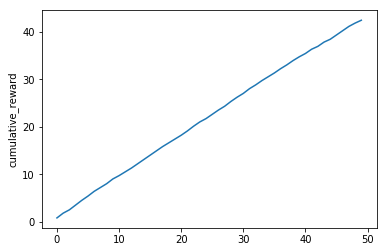

In [7]:
import matplotlib.pyplot as plt
plt.plot(cumulative_reward)
plt.ylabel('cumulative_reward')
plt.show()

# Cumulative reward for the two arms scenario, as expected, we grow with a rate of around
# ~ 0.9 * 0.9 + 0.1 * 0.5 * 0.9 = 0.855 per step. In 90% of cases we pick the best item, which we quickly learn to be
# the better performing step, and in the other 10% of cases we have a 50% chance to pick a more profitable arm.

In [10]:
# Conduct the experiment for 10 arms and e = 0.1. Note that we used a mean from uniform [0, 1].
arms = []
for i in range(10):
    arms.append(NormalArm(np.random.rand(), 1))
chosen_arms, avg_reward, cumulative_reward = test_bandit(bandit = EpsilonGreedyBandit(0.1,10),
                                                         arms = arms, n_episodes=1000, n_steps=1000)

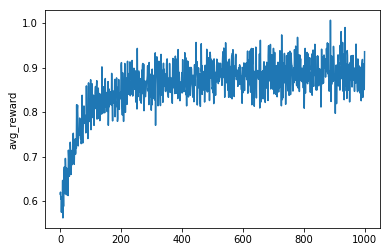

In [12]:
# As we can see, sooner or later our average reward improves, as we find the best arm.
import matplotlib.pyplot as plt
plt.plot(avg_reward)
plt.ylabel('avg_reward')
plt.show()

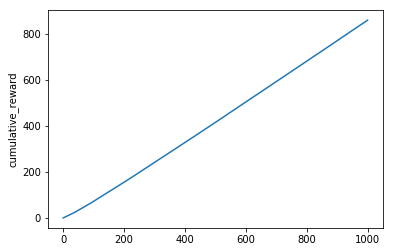

In [13]:
# Again, on average cumulative return grows linearly

import matplotlib.pyplot as plt
plt.plot(cumulative_reward)
plt.ylabel('cumulative_reward')
plt.show()

In [32]:
# Conduct the experiment for 10 arms with proper setup (mean is normal(0,1)).
# Try several values of epsilon and record the result.

arms = []
for i in range(10):
    arms.append(NormalArm(np.random.normal(0, 1), 1))

chosen_per_eps = {}
avg_per_eps = {}
cumulative_per_eps = {}
best_per_eps = {}

for eps in [0.02, 0.05, 0.1, 0.2, 0.5, 0.9, 1.0]:
    chosen_arms, avg_reward, cumulative_reward, best_cnt = test_bandit(bandit = EpsilonGreedyBandit(eps,10),
                                                         arms = arms, n_episodes=1000, n_steps=1000)
    chosen_per_eps[eps] = chosen_arms
    avg_per_eps[eps] = avg_reward
    cumulative_per_eps[eps] = cumulative_reward
    best_per_eps[eps] = best_cnt


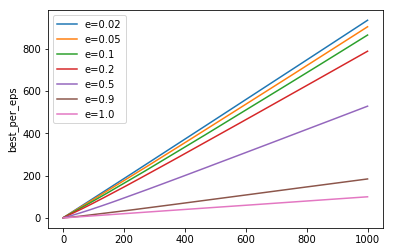

In [33]:
# Plot how often we ended up choosing the best arm (cumulative). For example, for eps = 1.0, we can see that the best
# decision is made in 10% of cases, since we have a 10% chance of picking the best out of 10 stocks. We see that
# that small epsilon values are performing the best here, as they end up finding the best stock and just keep taking
# it all the time.

for e in best_per_eps:
    plt.plot(best_per_eps[e], label='e=' + str(e))

plt.legend(loc='best')
plt.ylabel('best_per_eps')
plt.show()

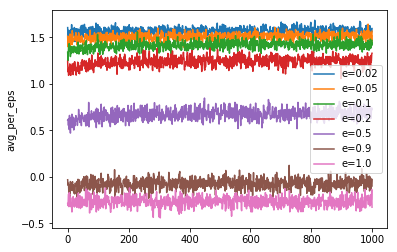

In [34]:
# Average profit per turn for each epsilon. Something is fishy here, I would expect this chart to look
# different.

for e in avg_per_eps:
    plt.plot(avg_per_eps[e], label='e=' + str(e))

plt.legend(loc='best')
plt.ylabel('avg_per_eps')
plt.show()

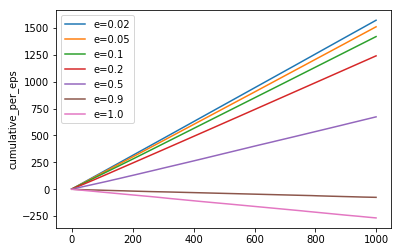

In [35]:
# Cumulative profit over time (averaged per episode). We see that the small epsilons perform the best, which
# is expected from the best_per_eps chart. An interesting detail is that eps=1.0 went into negatives, but that could
# easily be the case - basically if the sum of our 10 normals is negative, that could happen (and the sum of
# normals is again normal, so we had roughly a 50% chance of that happening)

for e in cumulative_per_eps:
    plt.plot(cumulative_per_eps[e], label='e=' + str(e))

plt.legend(loc='best')
plt.ylabel('cumulative_per_eps')
plt.show()